In [64]:
import random
from collections import namedtuple
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from maze_env import Maze

# 定义命名元组 Transition 为环境中的单个转换，将 状态(state,action）: 结果(next_state,reward）
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))


# 循环缓冲区类别，保存最近观察到的转换，有点儿像dataset
class ReplayMemory(object):
    """ 缓存最近观察到的转换 """

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """将 Transition 加入缓存区"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """缓存区中 抽取 Transition """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class MLP(nn.Module):
    """ 充当 Q-table 的作用 """

    def __init__(self, n_features, n_actions):
        """ 构造一个 2 层神经网络  """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_features, 10)
        self.head = nn.Linear(10, n_actions)

    # 单元素或批次计算下次action
    def forward(self, x):  #
        """
        x : size = (batch_size, n_feature_tenosr)
        """
        x = F.relu(self.fc1(x.float()))
        x = self.head(x)
        return x  # todo 输出形状


class DQN(object):

    def __init__(self, n_actions, n_features, memory_size=500, batch_size=32,
                 learning_rate=0.01, gamma=0.9, e_greedy=0.9, e_greedy_increment=None,
                 target_update_step=10, output_graph=False, ):

        self.n_actions = n_actions
        self.n_features = n_features

        self.memory_size = memory_size  # 记忆上限
        self.batch_size = batch_size  # 每次更新时从 memory 里面取多少记忆出来

        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon_max = e_greedy  # epsilon 的最大值
        self.epsilon_increment = e_greedy_increment  # epsilon 的增量
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max  # 是否开启探索模式, 并逐步减少探索次数

        self.target_update_step = target_update_step  # 更换 target_net 的步数
        self.learn_step_counter = 0  # 记录学习次数 (用于判断是否更换 target_net 参数)

        # 创建缓存区
        self.memory = ReplayMemory(self.memory_size)

        # 创建 [policy_net, target_net]
        self.policy_net = MLP(self.n_features, self.n_actions)
        self.target_net = MLP(self.n_features, self.n_actions)

        # 输出 tensorboard 文件
        if output_graph:
            # $ tensorboard --logdir=logs
            SummaryWriter("logs/", self.sess.graph)

        self.cost_his = []  # 记录所有 cost 变化, 用于最后 plot 出来观看

    def store_transition(self, s, a, s_, r, done):
        """ 记录 一条 Transition

        Args:
            s: 当前状态 需要 转换 tensor
            a: 当前行为 需要 转换 tensor
            s_: 下一步状态 需要 转换 tensor
            r: 真实reward 需要 转换 tensor

        """

        if type(s) is np.ndarray:
            s = torch.from_numpy(s).unsqueeze(0)
        if type(s_) is np.ndarray:
            s_ = torch.from_numpy(s_).unsqueeze(0)

        if type(r) is int:
            r = torch.tensor([r])
        if type(done) is bool:
            done = torch.tensor([done])  # batch_size
        self.memory.push(s, a, s_, r, done)

    def choose_action(self, state):
        """ 决策 一条 state 的行为

        Args:
            state: tensor 当前状态 size(1,n_feature)

        Returns:
            actions: size=(1)

        """
        if type(state) is np.ndarray:
            state = torch.from_numpy(state).unsqueeze(0)

        if random.random() >= self.epsilon:  # 大于贪婪限制，随机筛选行为
            actions = torch.tensor([random.randrange(self.n_actions)], dtype=torch.long)  # size=(1)
        else:  # 小于贪婪限制，计算行为
            with torch.no_grad():
                policy_net_out = self.policy_net(state)  # size = (1,n_actions)
                actions = policy_net_out.max(1).indices  # Size([1])
        return actions

    def learn(self):

        if len(self.memory) < self.batch_size:  # 足够数据量进行学习，否则不学习
            return

        transition_list = self.memory.sample(self.batch_size)
        # a = zip(*transitions) 横向整体变成纵向；
        # Transition(*a)  # 将 a 拆解后 作为参数进入 Transition
        # 相当于从 dict 变成了 dataFrame
        batch_trans = Transition(*zip(*transition_list))  # 等价 Transition(*tuple(zip(*transitions)))

        # 判断 next_state 是否为空 布尔索引
        # not_final_flag = torch.tensor(tuple(map(lambda s: s is not None, batch_trans.next_state)), dtype=torch.bool)
        done_batch = torch.cat(batch_trans.done, dim=0)  # size(batch_size)
        not_final_flag = ~done_batch  # size(batch_size)

        # 将非空 next_state 的size(1,-1) list 拼接成 大size(n,-1)
        # not_final_next_state_batch = torch.cat([s for s in batch_trans.next_state if s is not None], dim=0)
        next_state_batch = torch.cat(batch_trans.state, dim=0)  # size(batch_size, n_features)
        not_final_next_state_batch = next_state_batch[not_final_flag]  # size(nf_batch_size, n_features)

        state_batch = torch.cat(batch_trans.state, dim=0)  # size(batch_size, n_features)
        action_batch = torch.cat(batch_trans.action, dim=0)  # size(batch_size)
        reward_batch = torch.cat(batch_trans.reward, dim=0)  # size(batch_size)

        # 计算 policy_net 得分 Q估计
        policy_net_out = self.policy_net(state_batch)  # 计算评估网络前馈 size(batch_size,n_actions)
        # 以 action_batch 为索引，选择对应的得分
        state_action_values = policy_net_out.gather(dim=1,
                                                    index=action_batch.unsqueeze(0))  # 返回同index: size(batch_size,1)

        # 计算下个状态的 target_net 得分
        next_state_values = torch.zeros(self.batch_size)  # size(batch_size)
        target_net_out = self.target_net(not_final_next_state_batch)  # size(nf_batch_size,n_actions)
        next_state_values[not_final_flag] = target_net_out.max(1)[0].detach()  # size(batch_size)，赋值并取消追踪

        # 计算下一个状态的总得分 现实
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch  # size(batch_size)

        # 计算损失函数 huber 损失
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(0))

        # Optimize the model
        # 定义损失函数和优化器
        optimizer = optim.RMSprop(self.policy_net.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss.backward()

        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)  # 对参数值进行截取，相当于正则化
        optimizer.step()

        # 逐渐增加 epsilon, 降低行为的随机性
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max

        self.cost_his.append(loss)
        self.learn_step_counter += 1  # 记录学习次数

        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_step == 0:
            # 满足学习步数限制，更新target_net的参数
            self.target_net.load_state_dict(self.policy_net.state_dict())

    # 输出学习过程中的 cost 变化曲线
    def plot_cost(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(16, 4))
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()


def maze_update(env, RL, episodes=100, learn=True):
    # 学习 100 回合
    temp_step = 0
    for episode in range(episodes):
        # 初始化 state 的观测值
        state = env.reset()
        episode_step = 0
        while True:
            env.render()  # 更新可视化环境
            action = RL.choose_action(state)  # RL 大脑根据 state 的观测值挑选 action
            state_, reward, done = env.step(action)
            if learn:
                RL.store_transition(state, action, state_, reward, done)  # 记忆
                RL.learn()  # 学习 积累足够数据量了
            episode_step +=1
            state = state_
            if done:  # 回合结束，跳出本轮循环
                break
        if learn:
            print(episode, 'episode,', RL.learn_step_counter - temp_step, 'step_counter, 结束')
            temp_step = RL.learn_step_counter
        else:
            if reward == -1:
                print(episode, 'episode,', episode_step, 'step_counter, 失败结束')    
            elif reward == 1:
                print(episode, 'episode,', episode_step, 'step_counter, 成功结束')    
        # print(RL.policy_net.state_dict()['fc1.bias'])  
        
    if not learn:
        print('测试结束')
    else :
        print('学习结束')
    env.destroy()

    return RL

In [66]:
    env = Maze('train')
    n_actions = env.n_actions
    n_features = env.n_features
    RL = DQN(n_actions, n_features, memory_size=256, batch_size=8,
             learning_rate=0.01, gamma=0.9, e_greedy=0.9, e_greedy_increment=None,
             target_update_step=10, output_graph=False)
    
    print(RL.policy_net.state_dict()['fc1.bias'])
    RL = maze_update(env, RL, episodes=2, learn=True)
    # RL.plot_cost()
    
    print(RL.policy_net.state_dict()['fc1.bias'])
    env = Maze('test')
    RL = maze_update(env, RL, episodes=1, learn=False)

tensor([-0.4281,  0.3159,  0.2801,  0.5787,  0.0907, -0.2338, -0.3863, -0.3061,
        -0.0495, -0.5532])
0 episode, 94 step_counter, 结束
tensor([-0.4281,  0.2159,  0.0802,  0.0787, -0.0093, -0.2338, -0.4863, -0.3061,
        -0.0495, -0.5532])
1 episode, 52 step_counter, 结束
tensor([-0.4281,  0.1159, -0.0198, -0.0213, -0.1093, -0.2338, -0.4863, -0.3061,
        -0.1495, -0.5532])
学习结束
tensor([-0.4281,  0.1159, -0.0198, -0.0213, -0.1093, -0.2338, -0.4863, -0.3061,
        -0.1495, -0.5532])
0 episode, 1341 step_counter, 失败结束
tensor([-0.4281,  0.1159, -0.0198, -0.0213, -0.1093, -0.2338, -0.4863, -0.3061,
        -0.1495, -0.5532])
测试结束


In [1]:
import random
from collections import namedtuple
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from maze_env import Maze

In [2]:
# 定义命名元组 Transition 为环境中的单个转换，将 状态(state,action）: 结果(next_state,reward）
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

# 循环缓冲区类别，保存最近观察到的转换，有点儿像dataset
class ReplayMemory(object):
    """ 缓存最近观察到的转换 """

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """将 Transition 加入缓存区"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """缓存区中 抽取 Transition """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class MLP(nn.Module):
    """ 充当 Q-table 的作用 """

    def __init__(self, n_features, n_actions):
        """ 构造一个 2 层神经网络  """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_features, 10)
        self.head = nn.Linear(10, n_actions)

    # 单元素或批次计算下次action
    def forward(self, x):  # 
        """ 
        x : size = (batch_size, n_feature_tenosr)
        """
        x = F.relu(self.fc1(x.float()))
        x = self.head(x)
        return x  # todo 输出形状

In [4]:
class DQN(object):

    def __init__(self, n_actions, n_features, memory_size=500, batch_size=32,
                 learning_rate=0.01, gamma=0.9, e_greedy=0.9, e_greedy_increment=None,
                 target_update_step=10, output_graph=False, ):

        self.n_actions = n_actions
        self.n_features = n_features

        self.memory_size = memory_size  # 记忆上限
        self.batch_size = batch_size  # 每次更新时从 memory 里面取多少记忆出来

        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon_max = e_greedy  # epsilon 的最大值
        self.epsilon_increment = e_greedy_increment  # epsilon 的增量
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max  # 是否开启探索模式, 并逐步减少探索次数

        self.target_update_step = target_update_step  # 更换 target_net 的步数
        self.learn_step_counter = 0  # 记录学习次数 (用于判断是否更换 target_net 参数)

        # 创建缓存区
        self.memory = ReplayMemory(self.memory_size)

        # 创建 [policy_net, target_net]
        self.policy_net = MLP(self.n_features, self.n_actions)
        self.target_net = MLP(self.n_features, self.n_actions)

        # 输出 tensorboard 文件
        if output_graph:
            # $ tensorboard --logdir=logs
            SummaryWriter("logs/", self.sess.graph)

        self.cost_his = []  # 记录所有 cost 变化, 用于最后 plot 出来观看

    def store_transition(self, s, a, s_, r, done):
        """ 记录 一条 Transition

        Args:
            s: 当前状态 需要 转换 tensor
            a: 当前行为 需要 转换 tensor 
            s_: 下一步状态 需要 转换 tensor
            r: 真实reward 需要 转换 tensor

        """
        
        if type(s) is np.ndarray:
            s = torch.from_numpy(s).unsqueeze(0)
        if type(s_) is np.ndarray:
            s_ = torch.from_numpy(s_).unsqueeze(0)
            
        if type(r) is int:
            r = torch.tensor([r])
        if type(done) is bool:
            done = torch.tensor([done]) # batch_size
        self.memory.push(s, a, s_, r, done)
        

    def choose_action(self, state):
        """ 决策 一条 state 的行为

        Args:
            state: tensor 当前状态 size(1,n_feature)
        
        Returns:
            actions: size=(1) 

        """
        if type(state) is np.ndarray:
            state = torch.from_numpy(state).unsqueeze(0)
        
        if random.random() >= self.epsilon:  # 大于贪婪限制，随机筛选行为
            actions = torch.tensor([random.randrange(self.n_actions)], dtype=torch.long)  # size=(1)
        else:  # 小于贪婪限制，计算行为
            with torch.no_grad():
                policy_net_out = self.policy_net(state) # size = (1,n_actions)
                actions = policy_net_out.max(1).indices  # Size([1]) 
        return actions

    def learn(self):

        if len(self.memory) < self.batch_size:  # 足够数据量进行学习，否则不学习
            return

        transition_list = self.memory.sample(self.batch_size)
        # a = zip(*transitions) 横向整体变成纵向；
        # Transition(*a)  # 将 a 拆解后 作为参数进入 Transition
        # 相当于从 dict 变成了 dataFrame
        batch_trans = Transition(*zip(*transition_list))  # 等价 Transition(*tuple(zip(*transitions)))

        # 判断 next_state 是否为空 布尔索引
        # not_final_flag = torch.tensor(tuple(map(lambda s: s is not None, batch_trans.next_state)), dtype=torch.bool)
        done_batch = torch.cat(batch_trans.done,dim=0)  # size(batch_size)
        not_final_flag = ~done_batch  # size(batch_size)

        # 将非空 next_state 的size(1,-1) list 拼接成 大size(n,-1)
        # not_final_next_state_batch = torch.cat([s for s in batch_trans.next_state if s is not None], dim=0)
        next_state_batch = torch.cat(batch_trans.state, dim=0)  # size(batch_size, n_features)
        not_final_next_state_batch = next_state_batch[not_final_flag]  # size(nf_batch_size, n_features)

        state_batch = torch.cat(batch_trans.state, dim=0)  # size(batch_size, n_features)
        action_batch = torch.cat(batch_trans.action, dim=0)  # size(batch_size)
        reward_batch = torch.cat(batch_trans.reward, dim=0)  # size(batch_size)

        # 计算 policy_net 得分 Q估计
        policy_net_out = self.policy_net(state_batch)  # 计算评估网络前馈 size(batch_size,n_actions)
        # 以 action_batch 为索引，选择对应的得分
        state_action_values = policy_net_out.gather(dim=1, index=action_batch.unsqueeze(0))  # 返回同index: size(batch_size,1)

        # 计算下个状态的 target_net 得分
        next_state_values = torch.zeros(self.batch_size)  # size(batch_size)
        target_net_out = self.target_net(not_final_next_state_batch)  # size(nf_batch_size,n_actions)
        next_state_values[not_final_flag] = target_net_out.max(1)[0].detach()  # size(batch_size)，赋值并取消追踪

        # 计算下一个状态的总得分 现实
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch  # size(batch_size)

        # 计算损失函数 huber 损失
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(0))

        # Optimize the model
        # 定义损失函数和优化器
        optimizer = optim.RMSprop(self.policy_net.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss.backward()

        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)  # 对参数值进行截取，相当于正则化
        optimizer.step()

        # 逐渐增加 epsilon, 降低行为的随机性
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
       
        self.cost_his.append(loss)        
        self.learn_step_counter += 1  # 记录学习次数

        
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_step == 0:
            # 满足学习步数限制，更新target_net的参数
            self.target_net.load_state_dict(self.policy_net.state_dict())
            
    # 输出学习过程中的 cost 变化曲线
    def plot_cost(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(16,4))
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()

In [36]:
def maze_update(env, RL, episodes=100, learn=True):
    # 学习 100 回合
    temp_step = 0
    for episode in range(episodes):
        # 初始化 state 的观测值
        state = env.reset()
        while True:
            env.render()  # 更新可视化环境
            action = RL.choose_action(state) # RL 大脑根据 state 的观测值挑选 action
            state_, reward, done = env.step(action)
            RL.store_transition(state, action, state_, reward, done)  # 记忆
            RL.learn()  # 学习 积累足够数据量了
            state = state_
            if done:  # 回合结束，跳出本轮循环
                break
        print(episode,'episode,',RL.learn_step_counter-temp_step,'step_counter, 结束')
        temp_step = RL.learn_step_counter
        
    if not learn:
        if reward == -1:
            print('测试失败')
        elif reward == 1:
            print('测试成功')
    else:
        print('学习结束')
    env.destroy()
    
    return RL

In [37]:
env = Maze()
n_actions = env.n_actions
n_features = env.n_features

In [38]:
RL = DQN(n_actions, n_features,memory_size=256, batch_size=8,
        learning_rate=0.01, gamma=0.9, e_greedy=0.9, e_greedy_increment=None,
        target_update_step=10, output_graph=False)

In [39]:
RL = maze_update(env, RL, episodes=10)

0 episode, 174 step_counter, 结束
1 episode, 18 step_counter, 结束
2 episode, 30 step_counter, 结束
3 episode, 124 step_counter, 结束
4 episode, 54 step_counter, 结束
5 episode, 130 step_counter, 结束
6 episode, 16 step_counter, 结束
7 episode, 14 step_counter, 结束
8 episode, 62 step_counter, 结束
9 episode, 50 step_counter, 结束
学习结束


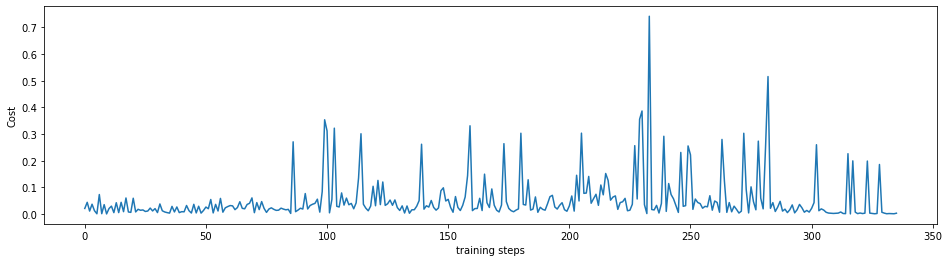

In [40]:
RL.plot_cost()

In [11]:
RL.epsilon

0.9

In [12]:
env.destroy()

TclError: can't invoke "destroy" command: application has been destroyed

In [17]:
RL.learn_step_counter

96

In [ ]:
def run_maze():
    step = 0
    for episode in range(10):
        # initial state
        state = env.reset()  # ndarray()

        while True:
            # fresh env
            env.render()
            # RL choose action based on state
            action = RL.choose_action(state) 
            # RL take action and get next state and reward
            state_, reward, done = env.step(action)
            RL.store_transition(state, action, state_, reward, done)
            if (step > 10) and (step % 5 == 0):  # 替换200次以上，才进行学习
                RL.learn()
            # swap state
            state = state_
            # break while loop when end of this episode
            if done:
                break
            step += 1
    print('game over')
    env.destroy()

In [ ]:

if __name__ == "__main__":
    # maze game
    env = Maze()
    RL = DQN(env.n_actions, env.n_features,
             learning_rate=0.01,
             reward_decay=0.9,
             e_greedy=0.9,
             replace_target_iter=200,
             memory_size=2000,
             # output_graph=True
             )
    env.after(100, run_maze)
    env.mainloop()
    # RL.plot_cost()

In [ ]:
# state = env.reset()

# env.render()

# action = RL.choose_action(state)

# state_, reward, done = env.step(action)

# RL.store_transition(state, action, state_, reward, True)
# RL.store_transition(state, action, state_, reward, False)

# RL.learn()

# state = torch.from_numpy(state) # size(1,2) batch_size, n_feature

# state

# action = RL.choose_action(state)
# action

# state_, reward, done = env.step(action.item())

# RL.store_transition(state, action, state_, reward, True)
# RL.store_transition(state, action, state_, reward, False)

# transition_list = RL.memory.sample(RL.batch_size)

# transition_list

# batch_trans = Transition(*zip(*transition_list)) 

# done_batch = torch.cat(batch_trans.done,dim=0)

# next_state_batch = torch.cat(batch_trans.state, dim=0)

# next_state_batch

# next_state_batch[done_batch]

# state_batch = torch.cat(batch_trans.state, dim=0)  # size(n,n_features)
# action_batch = torch.cat(batch_trans.action, dim=0)  # size(n,1)
# reward_batch = torch.cat(batch_trans.reward, dim=0)  # size(n,1)

# state_batch